In [1]:
import newick
import numpy as np
import pandas as pd
import scanpy as sc
from numpy import random

from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut

import seaborn as sns
import matplotlib.pyplot as plt

rseed = 0
random.seed(rseed)

In [2]:
newick_string = "(B:2000,C:2000,D:2000,E:2000)A:2000;"
#newick_string = "(B:2000,C:2000,D:2000)A:2000;"

#t = tree.Tree.from_newick(newick_string, genes=1000, modules=25)
t = tree.Tree.from_newick(newick_string, genes=1500, modules=100)
sample_time = np.arange(0, t.get_max_time())

In [3]:
uMs, Ws, Hs = sim.simulate_lineage(t, a=0.05)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

/opt/conda/envs/scvi-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [4]:
alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G)) # used for final simulation
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1 # used for final simulation
X, pseudotimes, branch, scalings = sim.sample_whole_tree(t, 1, alpha=alpha, beta=beta) # used for final simulation

In [5]:
X1 = (X.transpose() / scalings).transpose()
adata = sc.AnnData(np.log(X1+1))

sc.pp.neighbors(adata, use_rep="X")
sc.tl.diffmap(adata)
dm1 = adata.obsm["X_diffmap"]
adata.obsm["X_umap"] = adata.obsm["X_diffmap"][:,1:3]
br_names1, indices1 = np.unique(branch, return_inverse=True)

/tmp/ipykernel_7723/3695850633.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(np.log(X1+1))


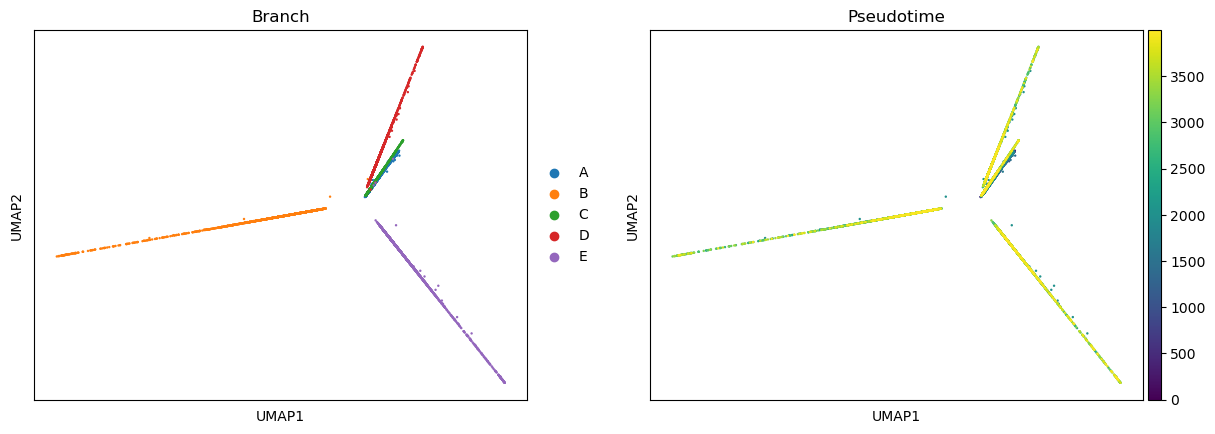

In [6]:
adata.obs['Branch']=branch
adata.obs['Pseudotime']=pseudotimes
sc.pl.umap(adata,color=['Branch','Pseudotime'])

In [7]:
sc.tl.rank_genes_groups(adata, 'Branch', method='wilcoxon')

In [8]:
markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

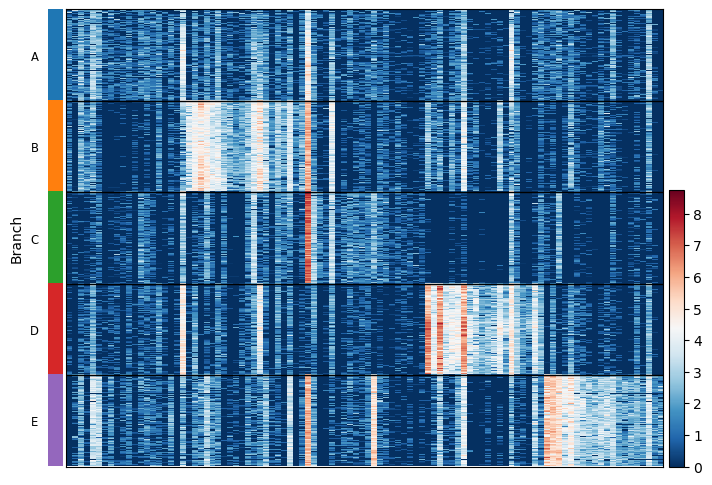

In [9]:
ax = sc.pl.heatmap(adata, markers.T.values.flatten().tolist(), groupby='Branch', cmap='RdBu_r')

In [10]:
import torch

In [11]:
Xc = X[adata.obs['Branch']=='A',:]
control = adata[adata.obs['Branch']=='A',:]

In [12]:
from sklearn.preprocessing import MinMaxScaler
ptime = control.obs['Pseudotime']
scaler = MinMaxScaler(feature_range=(0, 1))
ptime = scaler.fit_transform(np.expand_dims(ptime, 1))

In [13]:
pseudo = torch.Tensor(ptime).view(-1,1)

In [14]:
C = Xc.sum(1).mean() # * 10
print(C)

1186.6625


In [15]:
p_cont = Xc
q_cont = p_cont.sum(0)
P_cont = q_cont/q_cont.sum()
P_cont = torch.Tensor(P_cont).view(1,-1)

poisson = torch.distributions.Poisson((C+1) * torch.matmul(torch.ones(Xc.shape[0],1),P_cont))
cont = Xc + np.asarray(poisson.sample().detach().cpu())

Simulation 1

In [16]:
p1 = X[adata.obs['Branch']=='B',:]
q = p1.sum(0)
P = q/q.sum()
P = torch.Tensor(P).view(1,-1)

poisson_pert = torch.distributions.Poisson(C * torch.matmul(pseudo,P))
poisson_cont = torch.distributions.Poisson(C * torch.matmul((1-pseudo),P_cont))

pert1_basal = Xc + np.asarray(poisson_cont.sample().detach().cpu()).copy()
pert1_pert = np.asarray(poisson_pert.sample().detach().cpu()).copy()

pert1 = pert1_basal + pert1_pert

In [17]:
p2 = X[adata.obs['Branch']=='E',:]
q = p2.sum(0)
P = q/q.sum()
P = torch.Tensor(P).view(1,-1)

poisson_pert = torch.distributions.Poisson(C * torch.matmul(pseudo,P))
poisson_cont = torch.distributions.Poisson(C * torch.matmul((1-pseudo),P_cont))

pert2_basal = Xc + np.asarray(poisson_cont.sample().detach().cpu()).copy()
pert2_pert = np.asarray(poisson_pert.sample().detach().cpu()).copy()

pert2 = pert2_basal + pert2_pert 

Simulation 2

In [28]:
p1 = X[adata.obs['Branch']=='D',:]
q = p1.sum(0)
P = q/q.sum()
P = torch.Tensor(P).view(1,-1)

poisson_pert = torch.distributions.Poisson(C * torch.matmul(pseudo,P))
poisson_cont = torch.distributions.Poisson(C * torch.matmul((1-pseudo),P_cont))
pert1 = Xc + np.asarray(poisson_pert.sample().detach().cpu()) + np.asarray(poisson_cont.sample().detach().cpu())

In [29]:
p2 = X[adata.obs['Branch']=='D',:]
q = p2.sum(0)
P = q/q.sum()
P = torch.Tensor(P).view(1,-1)

poisson_pert = torch.distributions.Poisson(C * torch.matmul(pseudo,P) * 0.5)
poisson_cont = torch.distributions.Poisson(C * torch.matmul((1-pseudo),P_cont))
pert2 = Xc + np.asarray(poisson_pert.sample().detach().cpu()) + np.asarray(poisson_cont.sample().detach().cpu())

Simulation 3

In [16]:
p_shared = X[adata.obs['Branch']=='E',:]
q_shared = p_shared.sum(0)
P_shared = q_shared/q_shared.sum()
P_shared = torch.Tensor(P_shared).view(1,-1)

poisson_shared = torch.distributions.Poisson(C * torch.matmul((1-pseudo),P_shared))

In [17]:
p1 = X[adata.obs['Branch']=='B',:]
q = p1.sum(0)
P = q/q.sum()
P = torch.Tensor(P).view(1,-1)

poisson_pert = torch.distributions.Poisson(C * torch.matmul(pseudo,P))
pert1 = Xc + np.asarray(poisson_pert.sample().detach().cpu()) + np.asarray(poisson_shared.sample().detach().cpu())

In [18]:
p2 = X[adata.obs['Branch']=='D',:]
q = p2.sum(0)
P = q/q.sum()
P = torch.Tensor(P).view(1,-1)

poisson_pert = torch.distributions.Poisson(C * torch.matmul(pseudo,P))
pert2 = Xc + np.asarray(poisson_pert.sample().detach().cpu()) + np.asarray(poisson_shared.sample().detach().cpu())

In [18]:
control = sc.AnnData(X=cont)
control.obs['State']='A'
control.obs['Pseudotime']=ptime
control.obs['Condition']="Control"


control.layers['Basal']=control.X
control.layers['Pert']=control.X#np.zeros_like(control.X)

/tmp/ipykernel_7723/1844101849.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  control = sc.AnnData(X=cont)


In [19]:
perturb1 = sc.AnnData(X=pert1)
perturb1.obs['State']='A'
perturb1.obs['Pseudotime']=ptime
perturb1.obs['Condition']="Perturbation1"

perturb1.layers['Basal']=pert1_basal
perturb1.layers['Pert']=pert1_pert

/tmp/ipykernel_7723/2229478429.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  perturb1 = sc.AnnData(X=pert1)


In [20]:
perturb2 = sc.AnnData(X=pert2)
perturb2.obs['State']='A'
perturb2.obs['Pseudotime']=ptime
perturb2.obs['Condition']="Perturbation2"


perturb2.layers['Basal']=pert2_basal
perturb2.layers['Pert']=pert2_pert

/tmp/ipykernel_7723/1922459415.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  perturb2 = sc.AnnData(X=pert2)


In [21]:
sim1 = control.concatenate(perturb1,perturb2)
sim1.write("../data/simulation_data1v2.h5ad")

/opt/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) co